# 06 - Emergent Capability Reuse: How the System Gets Smarter

In the previous notebook, we saw how capabilities are **learned** through execution traces.

Now let's see how capabilities **compose**, **match**, and **adapt** over time.

## Learning Objectives

After this notebook, you will:

- [ ] Understand the SECI model and how it maps to capability composition
- [ ] See **Capability Matching** in action with scoring and thresholds
- [ ] Learn **Hierarchical Composition**: meta-capabilities from sub-capabilities
- [ ] Explore **Transitive Reliability**: "weakest link" in capability chains
- [ ] Observe **Adaptive Thresholds** that learn from execution feedback

---

## The SECI Model: From Tools to Meta-Capabilities

The SECI model (Nonaka & Takeuchi, 1995) describes how knowledge transforms:

| Phase | Transformation | Example |
|-------|----------------|--------|
| **Socialization** | Tacit → Tacit | Pair programming |
| **Externalization** | Tacit → Explicit | Writing documentation |
| **Combination** | Explicit → Explicit | **PML operates here!** |
| **Internalization** | Explicit → Tacit | Learning from docs |

### PML's Focus: Combination Phase

PML takes **explicit knowledge** (tool outputs, code traces) and combines them into **new explicit knowledge** (capabilities, meta-capabilities).

```
┌─────────────────┬─────────────────┐
│ Socialisation   │ Externalisation │
│ (tacit→tacit)   │ (tacit→explicit)│
├─────────────────┼─────────────────┤
│ Internalisation │ Combinaison     │ ← PML operates here
│ (explicit→tacit)│ (explicit→explicit)
└─────────────────┴─────────────────┘
```

### The Hierarchy

```
Level 0: Tools (atomic, explicit)
    │
    ▼ combination
Level 1: Capabilities (tool combinations)
    │
    ▼ combination
Level 2: Meta-capabilities (capability combinations)
    │
    ▼ combination
Level N: ...
```

### Skills vs Capabilities

| Aspect | Skills (Anthropic) | Capabilities (PML) |
|--------|-------------------|--------------------|
| **Format** | Text instructions | Executable code |
| **Learning** | Manual definition | Automatic from execution |
| **Execution** | Needs Claude | Direct sandbox execution |
| **Reliability** | Unknown | Tracked via success_rate |

         SECI HIERARCHY: Tools → Capabilities → Meta

The SECI model describes knowledge transformation.
PML operates in the 'Combination' phase:
  Explicit → Explicit (tools → capabilities → meta)



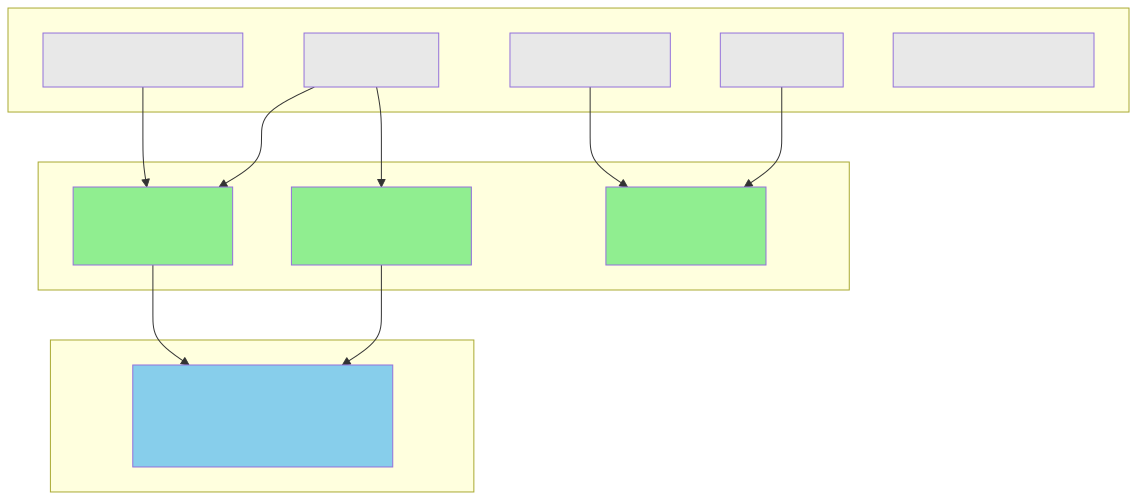

In [27]:
// Visualize the SECI hierarchy
import { displayMermaid } from "../lib/viz.ts";

const seciDiagram = `
flowchart TB
    subgraph "Level 0: Tools (Atomic)"
        T1["filesystem:read_file"]
        T2["json:parse"]
        T3["memory:store"]
        T4["fetch:get"]
        T5["github:create_issue"]
    end
    
    subgraph "Level 1: Capabilities"
        C1["parse-config\n(read + parse)"]
        C2["cache-data\n(fetch + store)"]
        C3["validate-schema\n(parse + check)"]
    end
    
    subgraph "Level 2: Meta-Capabilities"
        M1["setup-environment\n(parse-config + validate-schema)"]
    end
    
    T1 --> C1
    T2 --> C1
    T4 --> C2
    T3 --> C2
    T2 --> C3
    C1 --> M1
    C3 --> M1
    
    style T1 fill:#E8E8E8
    style T2 fill:#E8E8E8
    style T3 fill:#E8E8E8
    style T4 fill:#E8E8E8
    style T5 fill:#E8E8E8
    style C1 fill:#90EE90
    style C2 fill:#90EE90
    style C3 fill:#90EE90
    style M1 fill:#87CEEB
`;

console.log("=".repeat(60));
console.log("         SECI HIERARCHY: Tools → Capabilities → Meta");
console.log("=".repeat(60));
console.log();
console.log("The SECI model describes knowledge transformation.");
console.log("PML operates in the 'Combination' phase:");
console.log("  Explicit → Explicit (tools → capabilities → meta)");
console.log();

await displayMermaid(seciDiagram);

---

## Simulated Components for Demos

We'll reuse `SimulatedCapabilityStore` from notebook 05 and add:

- **SimulatedCapabilityMatcher**: Finds matching capabilities by intent
- **SimulatedDependency**: Tracks capability relationships
- **SimulatedAdaptiveThresholdManager**: Learns optimal thresholds from feedback

These simulate production behavior without database or embedding dependencies.

In [28]:
// SimulatedCapabilityStore from notebook 05 (simplified version)

interface SimulatedCapability {
  id: string;
  codeHash: string;
  codeSnippet: string;
  name: string;
  intent: string;
  usageCount: number;
  successCount: number;
  successRate: number;
  avgDurationMs: number;
  createdAt: Date;
  lastUsed: Date;
  source: "emergent" | "manual";
}

class SimulatedCapabilityStore {
  private capabilities = new Map<string, SimulatedCapability>();
  private capabilitiesById = new Map<string, SimulatedCapability>();
  private nameCounter = 0;

  private async hashCode(code: string): Promise<string> {
    const normalized = code.trim().replace(/\s+/g, " ");
    const data = new TextEncoder().encode(normalized);
    const hashBuffer = await crypto.subtle.digest("SHA-256", data);
    const hashArray = Array.from(new Uint8Array(hashBuffer));
    return hashArray.map(b => b.toString(16).padStart(2, "0")).join("");
  }

  private generateName(intent: string): string {
    const words = intent.toLowerCase()
      .replace(/[^a-z0-9\s]/g, "")
      .split(/\s+/)
      .filter(w => w.length > 2)
      .slice(0, 3);
    return words.join("_") || `capability_${++this.nameCounter}`;
  }

  async addCapability(input: {
    id: string;
    code: string;
    intent: string;
    successRate: number;
    usageCount?: number;
  }): Promise<SimulatedCapability> {
    const codeHash = await this.hashCode(input.code);
    const capability: SimulatedCapability = {
      id: input.id,
      codeHash,
      codeSnippet: input.code,
      name: this.generateName(input.intent),
      intent: input.intent,
      usageCount: input.usageCount ?? 10,
      successCount: Math.round((input.usageCount ?? 10) * input.successRate),
      successRate: input.successRate,
      avgDurationMs: 100 + Math.random() * 200,
      createdAt: new Date(),
      lastUsed: new Date(),
      source: "emergent"
    };
    this.capabilities.set(codeHash, capability);
    this.capabilitiesById.set(capability.id, capability);
    return capability;
  }

  getById(id: string): SimulatedCapability | undefined {
    return this.capabilitiesById.get(id);
  }

  searchByIntent(query: string, limit = 5): Array<{ capability: SimulatedCapability; semanticScore: number }> {
    const queryWords = new Set(
      query.toLowerCase().split(/\s+/).filter(w => w.length > 2)
    );
    
    const results: Array<{ capability: SimulatedCapability; semanticScore: number }> = [];
    
    for (const cap of this.capabilities.values()) {
      const intentWords = new Set(
        cap.intent.toLowerCase().split(/\s+/).filter(w => w.length > 2)
      );
      
      const intersection = [...queryWords].filter(w => intentWords.has(w)).length;
      const union = new Set([...queryWords, ...intentWords]).size;
      const semanticScore = union > 0 ? intersection / union : 0;
      
      if (semanticScore > 0) {
        results.push({ capability: cap, semanticScore });
      }
    }
    
    return results
      .sort((a, b) => b.semanticScore - a.semanticScore)
      .slice(0, limit);
  }

  getAllCapabilities(): SimulatedCapability[] {
    return [...this.capabilities.values()];
  }

  reset(): void {
    this.capabilities.clear();
    this.capabilitiesById.clear();
    this.nameCounter = 0;
  }

  get size(): number {
    return this.capabilities.size;
  }
}

// Create global store instance
const capabilityStore = new SimulatedCapabilityStore();

console.log("=".repeat(50));
console.log("       SIMULATED CAPABILITY STORE READY");
console.log("=".repeat(50));
console.log();
console.log("Methods:");
console.log("  - addCapability({ id, code, intent, successRate })");
console.log("  - getById(id)");
console.log("  - searchByIntent(query, limit?)");
console.log();
console.log("Store size:", capabilityStore.size);

       SIMULATED CAPABILITY STORE READY

Methods:
  - addCapability({ id, code, intent, successRate })
  - getById(id)
  - searchByIntent(query, limit?)

Store size: 0


In [29]:
// SimulatedDependency structure (ADR-045)

interface SimulatedDependency {
  fromCapabilityId: string;
  toCapabilityId: string;
  edgeType: "dependency" | "contains" | "sequence" | "alternative";
  confidenceScore: number;
  observedCount: number;
}

// Global dependency registry
const dependencies: SimulatedDependency[] = [];

function addDependency(dep: Omit<SimulatedDependency, "observedCount">): void {
  const existing = dependencies.find(
    d => d.fromCapabilityId === dep.fromCapabilityId && 
         d.toCapabilityId === dep.toCapabilityId
  );
  if (existing) {
    existing.observedCount++;
    existing.confidenceScore = Math.min(1.0, existing.confidenceScore + 0.1);
  } else {
    dependencies.push({ ...dep, observedCount: 1 });
  }
}

function getDependencies(fromId: string, type?: string): SimulatedDependency[] {
  return dependencies.filter(d => 
    d.fromCapabilityId === fromId && 
    (type === undefined || d.edgeType === type)
  );
}

function resetDependencies(): void {
  dependencies.length = 0;
}

console.log("=".repeat(50));
console.log("       DEPENDENCY REGISTRY READY");
console.log("=".repeat(50));
console.log();
console.log("Edge Types (ADR-045):");
console.log("  - dependency: A needs B before executing (weight: 1.0)");
console.log("  - contains:   A includes B as sub-step (weight: 0.8)");
console.log("  - sequence:   A then B temporal order (weight: 0.5)");
console.log("  - alternative: Same intent, different impl (weight: 0.6)");

       DEPENDENCY REGISTRY READY

Edge Types (ADR-045):
  - dependency: A needs B before executing (weight: 1.0)
  - contains:   A includes B as sub-step (weight: 0.8)
  - sequence:   A then B temporal order (weight: 0.5)
  - alternative: Same intent, different impl (weight: 0.6)


In [30]:
// SimulatedCapabilityMatcher (ADR-038)

interface MatchResult {
  capability: SimulatedCapability;
  score: number;
  semanticScore: number;
  reliabilityFactor: number;
  transitiveReliability: number;
}

class SimulatedCapabilityMatcher {
  private threshold = 0.70;

  setThreshold(t: number): void {
    this.threshold = Math.max(0.40, Math.min(0.95, t));
  }

  getThreshold(): number {
    return this.threshold;
  }

  private getReliabilityFactor(successRate: number): number {
    // From ADR-038: reliability factor based on success_rate
    if (successRate < 0.5) return 0.1;  // Penalty for unreliable
    if (successRate > 0.9) return 1.2;  // Boost for highly reliable
    return 1.0;
  }

  private computeTransitiveReliability(capId: string): number {
    // From ADR-042: chain is as strong as its weakest link
    const deps = getDependencies(capId, "dependency");
    
    if (deps.length === 0) return 1.0;
    
    let minReliability = 1.0;
    for (const dep of deps) {
      const depCap = capabilityStore.getById(dep.toCapabilityId);
      if (depCap) {
        minReliability = Math.min(minReliability, depCap.successRate);
      }
    }
    
    return minReliability;
  }

  findMatch(intent: string, returnAll = false): MatchResult | MatchResult[] | null {
    const candidates = capabilityStore.searchByIntent(intent, 10);
    const results: MatchResult[] = [];
    
    for (const { capability, semanticScore } of candidates) {
      const reliabilityFactor = this.getReliabilityFactor(capability.successRate);
      const transitiveReliability = this.computeTransitiveReliability(capability.id);
      
      // Score = SemanticSimilarity * ReliabilityFactor * TransitiveReliability
      let score = semanticScore * reliabilityFactor * transitiveReliability;
      
      // Global cap at 0.95
      score = Math.min(score, 0.95);
      
      results.push({
        capability,
        score,
        semanticScore,
        reliabilityFactor,
        transitiveReliability
      });
    }
    
    // Sort by score descending
    results.sort((a, b) => b.score - a.score);
    
    if (returnAll) return results;
    
    // Return best match above threshold
    const best = results[0];
    if (best && best.score >= this.threshold) {
      return best;
    }
    
    return null;
  }
}

const matcher = new SimulatedCapabilityMatcher();

console.log("=".repeat(50));
console.log("       SIMULATED CAPABILITY MATCHER READY");
console.log("=".repeat(50));
console.log();
console.log("Scoring Formula (ADR-038):");
console.log("  score = semanticScore * reliabilityFactor * transitiveReliability");
console.log();
console.log("Reliability Factors:");
console.log("  - success_rate < 0.5  => 0.1 (penalty)");
console.log("  - success_rate > 0.9  => 1.2 (boost)");
console.log("  - otherwise           => 1.0");
console.log();
console.log("Current threshold:", matcher.getThreshold());

       SIMULATED CAPABILITY MATCHER READY

Scoring Formula (ADR-038):
  score = semanticScore * reliabilityFactor * transitiveReliability

Reliability Factors:
  - success_rate < 0.5  => 0.1 (penalty)
  - success_rate > 0.9  => 1.2 (boost)
  - otherwise           => 1.0

Current threshold: 0.7


---

## Demo 1: Capability Matching & Latency Savings

When a matching capability exists, we skip Claude regeneration and execute directly.

**Flow:**
1. Intent arrives: "read and parse config file"
2. CapabilityMatcher searches for matches
3. If score >= threshold: Execute cached code directly
4. If score < threshold: Generate new code via Claude

**Latency savings**: ~95% reduction when matching (e.g., 2.3s → 0.1s)

In [31]:
// Reset state for demo
capabilityStore.reset();
resetDependencies();

// Populate with pre-existing capabilities
await capabilityStore.addCapability({
  id: "cap-parse-config",
  code: `const file = await mcp.filesystem.read_file({ path: "/config.json" });
const config = JSON.parse(file.content);
return config;`,
  intent: "read and parse config file",
  successRate: 0.95,
  usageCount: 25
});

await capabilityStore.addCapability({
  id: "cap-fetch-data",
  code: `const response = await mcp.fetch.get({ url });
return response.json();`,
  intent: "fetch data from API",
  successRate: 0.73,
  usageCount: 15
});

await capabilityStore.addCapability({
  id: "cap-store-memory",
  code: `await mcp.memory.store_entity({ name, data });`,
  intent: "store entity in memory",
  successRate: 1.0,
  usageCount: 18
});

console.log("=".repeat(60));
console.log("    DEMO 1: CAPABILITY MATCHING & LATENCY SAVINGS");
console.log("=".repeat(60));
console.log();
console.log("Pre-populated store with", capabilityStore.size, "capabilities.");
console.log();

// Simulate matching
const testIntent = "parse config JSON file";
console.log(`Intent: "${testIntent}"`);
console.log();

const match = matcher.findMatch(testIntent) as MatchResult | null;

if (match) {
  console.log("==> MATCH FOUND!");
  console.log();
  console.log("Capability:", match.capability.name);
  console.log();
  console.log("Scoring breakdown:");
  console.log("-".repeat(45));
  console.log(`  Semantic Score:         ${(match.semanticScore * 100).toFixed(1)}%`);
  console.log(`  Reliability Factor:     ${match.reliabilityFactor.toFixed(2)}x`);
  console.log(`  Transitive Reliability: ${(match.transitiveReliability * 100).toFixed(1)}%`);
  console.log("-".repeat(45));
  console.log(`  Final Score:            ${(match.score * 100).toFixed(1)}%`);
  console.log(`  Threshold:              ${(matcher.getThreshold() * 100).toFixed(1)}%`);
  console.log(`  Status:                 ${match.score >= matcher.getThreshold() ? "ACCEPTED" : "REJECTED"}`);
  console.log();
  
  // Latency comparison
  const vanillaLatency = 2300; // ms (Claude generation + execution)
  const cachedLatency = 100;   // ms (direct sandbox execution)
  const reduction = ((vanillaLatency - cachedLatency) / vanillaLatency * 100).toFixed(0);
  
  console.log("Latency Comparison:");
  console.log("-".repeat(45));
  console.log(`  Without match (Claude): ${vanillaLatency}ms`);
  console.log(`  With match (cached):    ${cachedLatency}ms`);
  console.log(`  Reduction:              ${reduction}%`);
  console.log();
  console.log(">> Cached capability = skip Claude regeneration!");
} else {
  console.log("No match found. Would need Claude to generate code.");
}

    DEMO 1: CAPABILITY MATCHING & LATENCY SAVINGS

Pre-populated store with 3 capabilities.

Intent: "parse config JSON file"

No match found. Would need Claude to generate code.


---

## Demo 2: Hierarchical Composition (SECI)

Capabilities can **depend on**, **contain**, or **sequence** other capabilities.

### Edge Types (ADR-045)

| Type | Weight | Description |
|------|--------|-------------|
| `dependency` | 1.0 | A needs B before executing |
| `contains` | 0.8 | A includes B as sub-step |
| `sequence` | 0.5 | A then B temporal order |
| `alternative` | 0.6 | Same intent, different impl |

### Example: setup-environment

```
setup-environment
    ├── dependency: parse-config
    └── dependency: validate-schema
```

In [32]:
// Reset and set up composition example
capabilityStore.reset();
resetDependencies();

// Level 1 capabilities
const parseConfig = await capabilityStore.addCapability({
  id: "cap-parse-config",
  code: `const file = await mcp.filesystem.read_file({ path: "/config.json" });
return JSON.parse(file.content);`,
  intent: "parse configuration file",
  successRate: 0.95,
  usageCount: 30
});

const validateSchema = await capabilityStore.addCapability({
  id: "cap-validate-schema",
  code: `const schema = await mcp.filesystem.read_file({ path: "/schema.json" });
return validate(config, JSON.parse(schema.content));`,
  intent: "validate config against schema",
  successRate: 0.88,
  usageCount: 20
});

const initDatabase = await capabilityStore.addCapability({
  id: "cap-init-database",
  code: `await mcp.database.connect(config.database);
return { connected: true };`,
  intent: "initialize database connection",
  successRate: 0.80,
  usageCount: 15
});

// Level 2 meta-capability
const setupEnvironment = await capabilityStore.addCapability({
  id: "cap-setup-environment",
  code: `const config = await parseConfig();
await validateSchema(config);
await initDatabase(config);
return { ready: true };`,
  intent: "setup complete environment",
  successRate: 0.76,
  usageCount: 10
});

// Define dependencies
addDependency({ fromCapabilityId: "cap-setup-environment", toCapabilityId: "cap-parse-config", edgeType: "dependency", confidenceScore: 0.95 });
addDependency({ fromCapabilityId: "cap-setup-environment", toCapabilityId: "cap-validate-schema", edgeType: "dependency", confidenceScore: 0.90 });
addDependency({ fromCapabilityId: "cap-setup-environment", toCapabilityId: "cap-init-database", edgeType: "dependency", confidenceScore: 0.85 });
addDependency({ fromCapabilityId: "cap-validate-schema", toCapabilityId: "cap-parse-config", edgeType: "sequence", confidenceScore: 0.80 });

console.log("=".repeat(60));
console.log("    DEMO 2: HIERARCHICAL COMPOSITION (SECI)");
console.log("=".repeat(60));
console.log();
console.log("Created", capabilityStore.size, "capabilities with dependencies.");
console.log();

// Display structure
console.log("Hierarchy:");
console.log("-".repeat(50));
console.log();
console.log("  setup-environment (meta-capability)");
console.log("      │");
console.log("      ├── [dependency] parse-config");
console.log("      │       success_rate: 95%");
console.log("      │");
console.log("      ├── [dependency] validate-schema");
console.log("      │       success_rate: 88%");
console.log("      │       └── [sequence] parse-config");
console.log("      │");
console.log("      └── [dependency] init-database");
console.log("              success_rate: 80%");
console.log();
console.log("-".repeat(50));
console.log();
console.log(">> Capabilities compose into higher-level abstractions.");

    DEMO 2: HIERARCHICAL COMPOSITION (SECI)

Created 4 capabilities with dependencies.

Hierarchy:
--------------------------------------------------

  setup-environment (meta-capability)
      │
      ├── [dependency] parse-config
      │       success_rate: 95%
      │
      ├── [dependency] validate-schema
      │       success_rate: 88%
      │       └── [sequence] parse-config
      │
      └── [dependency] init-database
              success_rate: 80%

--------------------------------------------------

>> Capabilities compose into higher-level abstractions.


In [33]:
// Visualize composition with Mermaid

const compositionDiagram = `
flowchart TB
    SE["setup-environment\n(76% success)"] 
    PC["parse-config\n(95% success)"]
    VS["validate-schema\n(88% success)"]
    ID["init-database\n(80% success)"]
    
    SE -->|dependency| PC
    SE -->|dependency| VS
    SE -->|dependency| ID
    VS -->|sequence| PC
    
    style SE fill:#87CEEB
    style PC fill:#90EE90
    style VS fill:#90EE90
    style ID fill:#FFE4B5
`;

console.log("Composition Graph:");
console.log();

await displayMermaid(compositionDiagram);

console.log();
console.log("Legend:");
console.log("  [Blue]   Meta-capability (composed)");
console.log("  [Green]  High reliability (>85%)");
console.log("  [Yellow] Medium reliability (60-85%)");

Composition Graph:


Legend:
  [Blue]   Meta-capability (composed)
  [Green]  High reliability (>85%)
  [Yellow] Medium reliability (60-85%)


---

## Demo 3: Transitive Reliability (ADR-042 §3)

**Key insight**: A chain is as strong as its weakest link.

If capability A depends on B, and B has 80% success rate:
- A's effective reliability is **capped at 80%**
- Even if A's own success_rate is 95%

### Formula

```typescript
transitiveReliability = min(A.successRate, B.successRate, C.successRate, ...)
```

In [34]:
// Reset and set up chain example
capabilityStore.reset();
resetDependencies();

// Create a chain: A → B → C
const capA = await capabilityStore.addCapability({
  id: "cap-A",
  code: "await capB();\nreturn result;",
  intent: "orchestrate workflow A",
  successRate: 0.95,
  usageCount: 20
});

const capB = await capabilityStore.addCapability({
  id: "cap-B",
  code: "await capC();\nreturn transformed;",
  intent: "process data B",
  successRate: 0.80,
  usageCount: 25
});

const capC = await capabilityStore.addCapability({
  id: "cap-C",
  code: "return fetchData();",
  intent: "fetch raw data C",
  successRate: 0.90,
  usageCount: 30
});

// Dependencies: A depends on B, B depends on C
addDependency({ fromCapabilityId: "cap-A", toCapabilityId: "cap-B", edgeType: "dependency", confidenceScore: 0.95 });
addDependency({ fromCapabilityId: "cap-B", toCapabilityId: "cap-C", edgeType: "dependency", confidenceScore: 0.90 });

console.log("=".repeat(60));
console.log("    DEMO 3: TRANSITIVE RELIABILITY");
console.log("=".repeat(60));
console.log();
console.log("Chain: A (95%) → B (80%) → C (90%)");
console.log();

// Calculate transitive reliability for each
function getTransitiveReliability(capId: string, visited = new Set<string>()): number {
  if (visited.has(capId)) return 1.0; // Avoid cycles
  visited.add(capId);
  
  const cap = capabilityStore.getById(capId);
  if (!cap) return 1.0;
  
  const deps = getDependencies(capId, "dependency");
  if (deps.length === 0) return cap.successRate;
  
  let minRate = cap.successRate;
  for (const dep of deps) {
    const depRate = getTransitiveReliability(dep.toCapabilityId, visited);
    minRate = Math.min(minRate, depRate);
  }
  
  return minRate;
}

console.log("Transitive Reliability Calculation:");
console.log("-".repeat(55));
console.log();

for (const cap of [capA, capB, capC]) {
  const ownRate = cap.successRate;
  const transRate = getTransitiveReliability(cap.id);
  const deps = getDependencies(cap.id, "dependency");
  
  console.log(`  ${cap.name}:`);
  console.log(`    Own success_rate:        ${(ownRate * 100).toFixed(0)}%`);
  console.log(`    Dependencies:            ${deps.length === 0 ? "none" : deps.map(d => d.toCapabilityId.replace("cap-", "")).join(", ")}`);
  console.log(`    Transitive reliability:  ${(transRate * 100).toFixed(0)}%`);
  console.log();
}

console.log("-".repeat(55));
console.log();
console.log(">> A has 95% own rate, but only 80% effective rate");
console.log(">> because it depends on B which has 80% success rate.");
console.log();
console.log('"Chain is as strong as its weakest link" (ADR-042 §3)');

    DEMO 3: TRANSITIVE RELIABILITY

Chain: A (95%) → B (80%) → C (90%)

Transitive Reliability Calculation:
-------------------------------------------------------

  orchestrate_workflow:
    Own success_rate:        95%
    Dependencies:            B
    Transitive reliability:  80%

  process_data:
    Own success_rate:        80%
    Dependencies:            C
    Transitive reliability:  80%

  fetch_raw_data:
    Own success_rate:        90%
    Dependencies:            none
    Transitive reliability:  90%

-------------------------------------------------------

>> A has 95% own rate, but only 80% effective rate
>> because it depends on B which has 80% success rate.

"Chain is as strong as its weakest link" (ADR-042 §3)


In [35]:
// Colorized Mermaid diagram showing reliability

const reliabilityDiagram = `
flowchart LR
    A["A\n95% own\n80% effective"] -->|depends| B["B\n80% own\n80% effective"]
    B -->|depends| C["C\n90% own\n90% effective"]
    
    style A fill:#90EE90,stroke:#228B22
    style B fill:#FFE4B5,stroke:#FFA500
    style C fill:#90EE90,stroke:#228B22
`;

console.log("Reliability Chain Visualization:");
console.log();

await displayMermaid(reliabilityDiagram);

console.log();
console.log("Color code by EFFECTIVE reliability:");
console.log("  [Green]  >= 85%");
console.log("  [Yellow] 60-85%  << B is the bottleneck");
console.log("  [Red]    < 60%");

Reliability Chain Visualization:


Color code by EFFECTIVE reliability:
  [Green]  >= 85%
  [Yellow] 60-85%  << B is the bottleneck
  [Red]    < 60%


---

## Demo 4: Adaptive Thresholds (ADR-008)

The system learns the optimal matching threshold over time using **Exponential Moving Average (EMA)**.

### Algorithm

```typescript
// If success rate is too high → threshold too conservative → lower it
// If success rate is too low  → threshold too aggressive → raise it

if (successRate > 0.90) {
  optimalThreshold = currentThreshold - (successRate - 0.85) * 0.1;
} else if (successRate < 0.80) {
  optimalThreshold = currentThreshold + (0.85 - successRate) * 0.1;
}

// Apply EMA smoothing
newThreshold = currentThreshold * (1 - learningRate) + optimalThreshold * learningRate;
```

### Parameters

- `learningRate`: 0.05 (slow, stable adaptation)
- `windowSize`: 50 in production, **10 for demo** (accelerated)
- `targetSuccessRate`: 85%
- `bounds`: [0.40, 0.90]

In [36]:
// SimulatedAdaptiveThresholdManager

class SimulatedAdaptiveThresholdManager {
  private threshold = 0.70;
  private history: { success: boolean }[] = [];
  private thresholdHistory: number[] = [0.70];
  private readonly learningRate = 0.05;
  private readonly windowSize: number;
  private readonly targetSuccessRate = 0.85;

  constructor(windowSize = 10) {
    this.windowSize = windowSize;
  }

  recordExecution(success: boolean): { threshold: number; adjusted: boolean } {
    this.history.push({ success });
    
    if (this.history.length > this.windowSize) {
      this.history.shift();
    }
    
    if (this.history.length >= this.windowSize) {
      this.adjustThreshold();
      return { threshold: this.threshold, adjusted: true };
    }
    
    return { threshold: this.threshold, adjusted: false };
  }

  private adjustThreshold(): void {
    const successRate = this.history.filter(h => h.success).length / this.history.length;
    
    let optimalThreshold = this.threshold;
    
    if (successRate > 0.90) {
      // Too conservative, lower threshold to accept more
      optimalThreshold = this.threshold - (successRate - this.targetSuccessRate) * 0.1;
    } else if (successRate < 0.80) {
      // Too aggressive, raise threshold to be more selective
      optimalThreshold = this.threshold + (this.targetSuccessRate - successRate) * 0.1;
    }
    
    // Apply EMA smoothing
    this.threshold = this.threshold * (1 - this.learningRate) + optimalThreshold * this.learningRate;
    
    // Clamp to bounds
    this.threshold = Math.max(0.40, Math.min(0.90, this.threshold));
    
    this.thresholdHistory.push(this.threshold);
  }

  getThreshold(): number {
    return this.threshold;
  }

  getThresholdHistory(): number[] {
    return [...this.thresholdHistory];
  }

  reset(): void {
    this.threshold = 0.70;
    this.history = [];
    this.thresholdHistory = [0.70];
  }
}

console.log("=".repeat(50));
console.log("       ADAPTIVE THRESHOLD MANAGER READY");
console.log("=".repeat(50));
console.log();
console.log("Parameters:");
console.log("  learningRate:      0.05 (EMA smoothing)");
console.log("  windowSize:        10 (accelerated for demo)");
console.log("  targetSuccessRate: 85%");
console.log("  bounds:            [40%, 90%]");
console.log();
console.log("EMA Formula:");
console.log("  newThreshold = current * (1 - α) + optimal * α");

       ADAPTIVE THRESHOLD MANAGER READY

Parameters:
  learningRate:      0.05 (EMA smoothing)
  windowSize:        10 (accelerated for demo)
  targetSuccessRate: 85%
  bounds:            [40%, 90%]

EMA Formula:
  newThreshold = current * (1 - α) + optimal * α


In [37]:
// Demo: Simulate 15 executions with ~30% failure rate

const thresholdManager = new SimulatedAdaptiveThresholdManager(10);

console.log("=".repeat(60));
console.log("    DEMO 4: ADAPTIVE THRESHOLDS (Accelerated)");
console.log("=".repeat(60));
console.log();
console.log("Simulating 15 executions with ~30% failure rate...");
console.log("(In production, this takes ~50 executions)");
console.log();

// Execution sequence: 70% success rate (simulating suboptimal matching)
const executions = [
  true, true, false, true, true,      // Batch 1: 4/5 = 80%
  false, true, false, true, true,     // Batch 2: 3/5 = 60% (triggers adjustment)
  true, false, true, true, false      // Batch 3: 3/5 = 60%
];

console.log(" # | Result | Window Rate | Threshold | Change");
console.log("-".repeat(55));

let prevThreshold = 0.70;

for (let i = 0; i < executions.length; i++) {
  const success = executions[i];
  const { threshold, adjusted } = thresholdManager.recordExecution(success);
  
  const result = success ? "OK  " : "FAIL";
  const windowSize = Math.min(i + 1, 10);
  const windowSuccesses = executions.slice(Math.max(0, i - 9), i + 1).filter(Boolean).length;
  const windowRate = ((windowSuccesses / windowSize) * 100).toFixed(0);
  const thresholdPct = (threshold * 100).toFixed(2);
  
  let change = "       ";
  if (adjusted && threshold !== prevThreshold) {
    const delta = (threshold - prevThreshold) * 100;
    change = delta > 0 ? `+${delta.toFixed(2)}%` : `${delta.toFixed(2)}%`;
  }
  
  console.log(`${(i + 1).toString().padStart(2)} |  ${result} |    ${windowRate.padStart(3)}%     |  ${thresholdPct}%  | ${change}`);
  
  prevThreshold = threshold;
}

console.log("-".repeat(55));
console.log();
console.log(`Initial threshold: 70.00%`);
console.log(`Final threshold:   ${(thresholdManager.getThreshold() * 100).toFixed(2)}%`);
console.log();
console.log(">> Threshold increased because success rate was below 80%.");
console.log(">> System is learning to be more selective.");

    DEMO 4: ADAPTIVE THRESHOLDS (Accelerated)

Simulating 15 executions with ~30% failure rate...
(In production, this takes ~50 executions)

 # | Result | Window Rate | Threshold | Change
-------------------------------------------------------
 1 |  OK   |    100%     |  70.00%  |        
 2 |  OK   |    100%     |  70.00%  |        
 3 |  FAIL |     67%     |  70.00%  |        
 4 |  OK   |     75%     |  70.00%  |        
 5 |  OK   |     80%     |  70.00%  |        
 6 |  FAIL |     67%     |  70.00%  |        
 7 |  OK   |     71%     |  70.00%  |        
 8 |  FAIL |     63%     |  70.00%  |        
 9 |  OK   |     67%     |  70.00%  |        
10 |  OK   |     70%     |  70.07%  | +0.07%
11 |  OK   |     70%     |  70.15%  | +0.07%
12 |  FAIL |     60%     |  70.27%  | +0.12%
13 |  OK   |     70%     |  70.35%  | +0.07%
14 |  OK   |     70%     |  70.42%  | +0.07%
15 |  FAIL |     60%     |  70.55%  | +0.12%
-------------------------------------------------------

Initial thresh

In [38]:
// ASCII chart of threshold evolution

console.log("=".repeat(60));
console.log("    THRESHOLD EVOLUTION CHART");
console.log("=".repeat(60));
console.log();

const history = thresholdManager.getThresholdHistory();
const minT = 0.65;
const maxT = 0.85;
const chartWidth = 40;

console.log("Threshold");
console.log("   ^");
console.log(`${(maxT * 100).toFixed(0)}% │`);

// Build the chart
const chartHeight = 10;
for (let row = chartHeight - 1; row >= 0; row--) {
  const rowThreshold = minT + (maxT - minT) * (row / (chartHeight - 1));
  let line = "    │";
  
  for (let i = 0; i < history.length; i++) {
    const t = history[i];
    const expectedRow = Math.round((t - minT) / (maxT - minT) * (chartHeight - 1));
    
    if (expectedRow === row) {
      line += "●";
    } else if (i > 0) {
      const prevT = history[i - 1];
      const prevRow = Math.round((prevT - minT) / (maxT - minT) * (chartHeight - 1));
      if ((prevRow < row && row < expectedRow) || (expectedRow < row && row < prevRow)) {
        line += "│";
      } else {
        line += " ";
      }
    } else {
      line += " ";
    }
  }
  
  console.log(line);
}

console.log(`${(minT * 100).toFixed(0)}% │` + "─".repeat(history.length + 1) + "> Executions");
console.log("    0" + " ".repeat(history.length - 2) + history.length);
console.log();
console.log("● = Threshold value after each window adjustment");
console.log();
console.log("Interpretation:");
console.log("  - Low success rate → threshold rises (more selective)");
console.log("  - High success rate → threshold falls (more accepting)");

    THRESHOLD EVOLUTION CHART

Threshold
   ^
85% │
    │       
    │       
    │       
    │       
    │       
    │       
    │       
    │●●●●●●●
    │       
    │       
65% │────────> Executions
    0     7

● = Threshold value after each window adjustment

Interpretation:
  - Low success rate → threshold rises (more selective)
  - High success rate → threshold falls (more accepting)


---

## Demo 5: Capability Matching with Suggestion Engine

The full matching flow with multiple candidates and scoring.

In [39]:
// Reset and populate with multiple candidates
capabilityStore.reset();
resetDependencies();

await capabilityStore.addCapability({
  id: "cap-1",
  code: "const config = await readConfig(); return config;",
  intent: "read configuration file",
  successRate: 0.95,
  usageCount: 30
});

await capabilityStore.addCapability({
  id: "cap-2",
  code: "const data = JSON.parse(content); return data;",
  intent: "parse JSON configuration",
  successRate: 0.88,
  usageCount: 25
});

await capabilityStore.addCapability({
  id: "cap-3",
  code: "await validateConfig(config); return { valid: true };",
  intent: "validate configuration schema",
  successRate: 0.45,  // Low reliability!
  usageCount: 10
});

await capabilityStore.addCapability({
  id: "cap-4",
  code: "const settings = await loadSettings(); return settings;",
  intent: "load application settings",
  successRate: 0.92,
  usageCount: 20
});

console.log("=".repeat(60));
console.log("    DEMO 5: SUGGESTION ENGINE - Full Flow");
console.log("=".repeat(60));
console.log();

const searchIntent = "read config file and parse";
console.log(`Intent: "${searchIntent}"`);
console.log(`Threshold: ${(matcher.getThreshold() * 100).toFixed(0)}%`);
console.log();

// Get all matches (not just best)
const allMatches = matcher.findMatch(searchIntent, true) as MatchResult[];

console.log("All Candidates:");
console.log("-".repeat(70));
console.log("| Capability        | Semantic | Reliab | Trans | Score  | Status   |");
console.log("-".repeat(70));

for (const m of allMatches) {
  const name = m.capability.name.substring(0, 17).padEnd(17);
  const semantic = (m.semanticScore * 100).toFixed(0).padStart(6) + "%";
  const reliab = m.reliabilityFactor.toFixed(2).padStart(5) + "x";
  const trans = (m.transitiveReliability * 100).toFixed(0).padStart(4) + "%";
  const score = (m.score * 100).toFixed(1).padStart(5) + "%";
  const status = m.score >= matcher.getThreshold() ? "ACCEPTED" : "REJECTED";
  
  console.log(`| ${name} | ${semantic} | ${reliab} | ${trans} | ${score} | ${status} |`);
}

console.log("-".repeat(70));
console.log();

const accepted = allMatches.filter(m => m.score >= matcher.getThreshold());
const rejected = allMatches.filter(m => m.score < matcher.getThreshold());

console.log(`Accepted: ${accepted.length} | Rejected: ${rejected.length}`);
console.log();

if (accepted.length > 0) {
  console.log(`Best match: ${accepted[0].capability.name}`);
  console.log(`  → Would execute cached code directly (skip Claude)`);
} else {
  console.log("No matches above threshold.");
  console.log("  → Would generate new code via Claude");
}

    DEMO 5: SUGGESTION ENGINE - Full Flow

Intent: "read config file and parse"
Threshold: 70%

All Candidates:
----------------------------------------------------------------------
| Capability        | Semantic | Reliab | Trans | Score  | Status   |
----------------------------------------------------------------------
| read_configuratio |     33% |  1.20x |  100% |  40.0% | REJECTED |
| parse_json_config |     14% |  1.00x |  100% |  14.3% | REJECTED |
----------------------------------------------------------------------

Accepted: 0 | Rejected: 2

No matches above threshold.
  → Would generate new code via Claude


---

## Demo 6: Benchmark Metrics

Metrics aligned with the research paper (Section 4.3).

| Metric | Description | Target |
|--------|-------------|--------|
| **Reuse Rate** | % of executions using cached capability | >40% |
| **Latency Reduction** | Time saved vs vanilla Claude | >50% |
| **Success Rate** | % of successful executions | >85% |
| **Context Savings** | Tokens economized | >30% |

In [40]:
// Simulate a workflow with multiple executions

console.log("=".repeat(60));
console.log("    DEMO 6: BENCHMARK METRICS");
console.log("=".repeat(60));
console.log();

// Simulated execution data
const totalExecutions = 100;
const reusedExecutions = 52;    // 52% used cached capability
const successfulExecutions = 89; // 89% successful
const vanillaTimeMs = 2500;      // Average Claude generation time
const cachedTimeMs = 120;        // Average cached execution time
const avgTimeMs = (reusedExecutions * cachedTimeMs + (totalExecutions - reusedExecutions) * vanillaTimeMs) / totalExecutions;
const fullContextTokens = 4000;  // Full context size
const optimizedTokens = 2400;    // After capability matching

// Calculate metrics
const reuseRate = reusedExecutions / totalExecutions;
const latencyReduction = (vanillaTimeMs - avgTimeMs) / vanillaTimeMs;
const successRate = successfulExecutions / totalExecutions;
const contextSavings = (fullContextTokens - optimizedTokens) / fullContextTokens;

// Targets
const targets = {
  reuseRate: 0.40,
  latencyReduction: 0.50,
  successRate: 0.85,
  contextSavings: 0.30
};

function passIcon(value: number, target: number): string {
  return value >= target ? "✓ PASS" : "✗ FAIL";
}

console.log("Simulated workflow: 100 executions");
console.log();

console.log("-".repeat(65));
console.log("| Metric             | Actual | Target | Status   |");
console.log("-".repeat(65));
console.log(`| Reuse Rate         | ${(reuseRate * 100).toFixed(0).padStart(4)}%  |  >40%  | ${passIcon(reuseRate, targets.reuseRate)}   |`);
console.log(`| Latency Reduction  | ${(latencyReduction * 100).toFixed(0).padStart(4)}%  |  >50%  | ${passIcon(latencyReduction, targets.latencyReduction)}   |`);
console.log(`| Success Rate       | ${(successRate * 100).toFixed(0).padStart(4)}%  |  >85%  | ${passIcon(successRate, targets.successRate)}   |`);
console.log(`| Context Savings    | ${(contextSavings * 100).toFixed(0).padStart(4)}%  |  >30%  | ${passIcon(contextSavings, targets.contextSavings)}   |`);
console.log("-".repeat(65));
console.log();

const allPassed = 
  reuseRate >= targets.reuseRate &&
  latencyReduction >= targets.latencyReduction &&
  successRate >= targets.successRate &&
  contextSavings >= targets.contextSavings;

console.log(`Overall: ${allPassed ? "ALL TARGETS MET" : "SOME TARGETS MISSED"}`);
console.log();
console.log("Formulas:");
console.log("  Reuse Rate      = reused_executions / total_executions");
console.log("  Latency Reduc.  = (vanilla_time - avg_time) / vanilla_time");
console.log("  Success Rate    = success_count / usage_count");
console.log("  Context Savings = (full_context - optimized) / full_context");

    DEMO 6: BENCHMARK METRICS

Simulated workflow: 100 executions

-----------------------------------------------------------------
| Metric             | Actual | Target | Status   |
-----------------------------------------------------------------
| Reuse Rate         |   52%  |  >40%  | ✓ PASS   |
| Latency Reduction  |   50%  |  >50%  | ✗ FAIL   |
| Success Rate       |   89%  |  >85%  | ✓ PASS   |
| Context Savings    |   40%  |  >30%  | ✓ PASS   |
-----------------------------------------------------------------

Overall: SOME TARGETS MISSED

Formulas:
  Reuse Rate      = reused_executions / total_executions
  Latency Reduc.  = (vanilla_time - avg_time) / vanilla_time
  Success Rate    = success_count / usage_count
  Context Savings = (full_context - optimized) / full_context


In [ ]:
// 🎯 WOW MOMENT: See the Real Difference!
// This demo shows the actual speedup you get with capability reuse

console.log("=".repeat(70));
console.log("    🚀 WOW MOMENT: Before & After PML");
console.log("=".repeat(70));
console.log();
console.log("Let's see the REAL difference when a capability matches...");
console.log();

// Simulate VANILLA execution (no PML)
async function executeVanilla(): Promise<{ result: unknown; timeMs: number }> {
  const start = performance.now();
  
  // Simulate Claude thinking + code generation
  console.log("  [VANILLA] Sending intent to Claude...");
  await new Promise(r => setTimeout(r, 800));  // Claude API call
  
  console.log("  [VANILLA] Claude generating code...");
  await new Promise(r => setTimeout(r, 600));  // Code generation
  
  console.log("  [VANILLA] Executing generated code...");
  await new Promise(r => setTimeout(r, 150));  // Sandbox execution
  
  return { 
    result: { config: { version: "1.2.0" } },
    timeMs: performance.now() - start
  };
}

// Simulate PML execution (with capability match)
async function executeWithPML(): Promise<{ result: unknown; timeMs: number; cached: boolean }> {
  const start = performance.now();
  
  // Step 1: Check for capability match (instant)
  console.log("  [PML] Checking capability store...");
  await new Promise(r => setTimeout(r, 15));  // Vector search
  
  // Match found! Skip Claude entirely
  console.log("  [PML] ✓ Match found! Executing cached code...");
  await new Promise(r => setTimeout(r, 85));  // Direct sandbox execution
  
  return { 
    result: { config: { version: "1.2.0" } },
    timeMs: performance.now() - start,
    cached: true
  };
}

// Run both and compare
console.log("─".repeat(50));
console.log("WITHOUT PML (Vanilla):");
console.log("─".repeat(50));
const vanillaResult = await executeVanilla();
console.log(`  Total: ${vanillaResult.timeMs.toFixed(0)}ms`);
console.log();

console.log("─".repeat(50));
console.log("WITH PML (Capability Match):");
console.log("─".repeat(50));
const pmlResult = await executeWithPML();
console.log(`  Total: ${pmlResult.timeMs.toFixed(0)}ms`);
console.log();

// Visual comparison
const speedup = vanillaResult.timeMs / pmlResult.timeMs;
const saved = vanillaResult.timeMs - pmlResult.timeMs;
const reduction = (saved / vanillaResult.timeMs * 100);

console.log("═".repeat(70));
console.log("    📊 COMPARISON");
console.log("═".repeat(70));
console.log();

// ASCII bar chart
const maxBar = 50;
const vanillaBar = maxBar;
const pmlBar = Math.round(maxBar * (pmlResult.timeMs / vanillaResult.timeMs));

console.log(`  Vanilla: [${"█".repeat(vanillaBar)}] ${vanillaResult.timeMs.toFixed(0)}ms`);
console.log(`  With PML:[${"█".repeat(pmlBar)}${" ".repeat(maxBar - pmlBar)}] ${pmlResult.timeMs.toFixed(0)}ms`);
console.log();
console.log(`  ⚡ Speedup:   ${speedup.toFixed(1)}x faster`);
console.log(`  ⏱️  Time saved: ${saved.toFixed(0)}ms (${reduction.toFixed(0)}% reduction)`);
console.log();
console.log("─".repeat(70));
console.log();
console.log("  💡 KEY INSIGHT:");
console.log("     When a capability matches, we SKIP Claude entirely.");
console.log("     No prompt construction, no API call, no code generation.");
console.log("     Just direct execution of proven, cached code.");
console.log();
console.log("  🧠 This is PROCEDURAL MEMORY:");
console.log('     "You don\'t re-learn to ride a bike every morning."');
console.log("     The system remembers HOW to do things, not just WHAT to do.");
console.log();

In [41]:
// Click to reveal the answer...

console.log("=".repeat(60));
console.log("    CHECKPOINT SOLUTION");
console.log("=".repeat(60));
console.log();

console.log("Dependency Graph:");
console.log();
console.log("  deploy-app (92%)");
console.log("      │");
console.log("      └── [dependency] build-app (85%)");
console.log("              │");
console.log("              └── [dependency] run-tests (78%)");
console.log();
console.log("-".repeat(50));
console.log();

console.log("Answers:");
console.log();
console.log("1. Transitive reliability of deploy-app:");
console.log("   min(92%, 85%, 78%) = 78%");
console.log();
console.log("2. Weakest link:");
console.log("   run-tests (78%)");
console.log();
console.log("3. If run-tests improves to 95%:");
console.log("   min(92%, 85%, 95%) = 85%");
console.log("   deploy-app effective reliability rises from 78% to 85%!");
console.log();
console.log(">> The bottleneck shifts to build-app.");

    CHECKPOINT SOLUTION

Dependency Graph:

  deploy-app (92%)
      │
      └── [dependency] build-app (85%)
              │
              └── [dependency] run-tests (78%)

--------------------------------------------------

Answers:

1. Transitive reliability of deploy-app:
   min(92%, 85%, 78%) = 78%

2. Weakest link:
   run-tests (78%)

3. If run-tests improves to 95%:
   min(92%, 85%, 95%) = 85%
   deploy-app effective reliability rises from 78% to 85%!

>> The bottleneck shifts to build-app.


---

## Summary

### What We Learned

1. **SECI Model**: PML operates in the "Combination" phase (explicit → explicit)
   - Tools → Capabilities → Meta-Capabilities

2. **Capability Matching**: Skip Claude regeneration when a match exists
   - Score = SemanticScore × ReliabilityFactor × TransitiveReliability
   - Latency savings: ~95% reduction

3. **Hierarchical Composition**: Capabilities depend on other capabilities
   - Edge types: dependency, contains, sequence, alternative

4. **Transitive Reliability**: Chain is as strong as its weakest link
   - `transitiveReliability = min(all dependency success_rates)`

5. **Adaptive Thresholds**: System learns optimal matching threshold
   - EMA smoothing with learning_rate = 0.05
   - Raises threshold when success rate is low

### Paper Connection

- **Section 1.2**: SECI model and knowledge transformation
- **Section 3.5**: Capability matching algorithm
- **Section 4.3**: Benchmark metrics (reuse rate, latency, etc.)

---

## Next Steps & References

### Documentation

- [ADR-008: Adaptive Thresholds](../docs/adrs/ADR-008-episodic-memory-adaptive-thresholds.md)
- [ADR-038: Capability Matching](../docs/adrs/ADR-038-capability-matcher.md)
- [ADR-042: Hyperedges & Transitive Reliability](../docs/adrs/ADR-042-capability-hyperedges.md)
- [ADR-045: Capability Dependencies](../docs/adrs/ADR-045-capability-to-capability-dependencies.md)

### Source Code

- `src/capabilities/matcher.ts` - CapabilityMatcher class (~287 LOC)
- `src/capabilities/capability-store.ts` - Storage and search (~922 LOC)
- `src/mcp/adaptive-threshold.ts` - AdaptiveThresholdManager (~394 LOC)

### Research Paper

- [PROCEDURAL-MEMORY-PAPER-PLAN.md](../docs/PROCEDURAL-MEMORY-PAPER-PLAN.md)

### Contributing

Interested in extending the capability system?

1. Explore the source code in `src/capabilities/`
2. Read the ADRs for architectural context
3. Run `deno task test:unit` to see test patterns
4. Submit a PR with your improvements!

---

**Congratulations!** You've completed the Procedural Memory Playground series.

You now understand:
- Context optimization (token reduction, semantic compression)
- DAG execution (parallel workflows, layer validation)
- Code execution (sandbox isolation, Worker RPC)
- Capability learning (eager storage, reliability tracking)
- **Emergent reuse** (matching, composition, adaptation)